In [1]:
import numpy as np
import pandas as pd
from dfply import *
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import timedelta
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')

# 데이터 정제 시 필요한 모듈들
import src.subjectlist_alignment.pairing as pairing   # 삽관 발관 페어링 관련 모듈
from src.subjectlist_alignment import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src.subjectlist_alignment import imputation as imp   # 결측치 대체 관련 모듈
from src.subjectlist_alignment import subject_classification as cls

import src.utils.utils as utils   # 기타 유틸리티 모듈
import src.data_extraction.access_database as db   # DB 연결 관련 모듈

In [2]:
# 변수를 붙일 subjectlist 데이터 가져오기

data_dir = '../outputs/subjectlist1.csv'
subjectlist1 = pd.read_csv(data_dir, index_col=0)
age = pd.read_csv('../outputs/age.csv')


# datetime 변환
time_cols = ['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime', 'reintubation_eventtime']
subjectlist1 = utils.to_datetime(subjectlist1, time_cols)
print(subjectlist1.shape)

# 데이터 단순화
cols = ['subject_id', 'hadm_id', 'stay_id', 'admittime', 'dischtime', 'deathtime', 'class']
# unique_hadms = list(subjectlist1.hadm_id.unique())
trimmed_table = subjectlist1[cols]

# age 와 결합
sl = pd.merge(trimmed_table, age[['subject_id', 'hadm_id', 'age']], on=['subject_id', 'hadm_id'], how='left')

sl['age'] = pd.to_numeric(sl['age'], errors='coerce')
sl['age'] = sl['age'].round(2)
sl.rename(columns={'age': 'age_original'}, inplace=True)   # 이름 변경. 비교 위함.

sl

Converted admittime to datetime.
Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
Converted reintubation_eventtime to datetime.
(9003, 29)


,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age_original
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,nonfailure,75.59
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-13 17:31:00,NaT,nonfailure,85.27
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,failure,85.06
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,nonfailure,85.06
...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30
8999,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30
9000,19999068,21606769,30143796,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,nonfailure,63.64
9001,19999442,26785317,32336619,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,nonfailure,43.88


### SOFA
- stay id 별로, starttime-endtime 값을 정의해서 -> 그 시점의 24hours_sofa 값을 가져오면 됨.
- 핵심은 이 지표를 얼마나 빈번히 수집할 것인가? (예: 24시간에 한 번?)

In [3]:
sofa = pd.read_csv('../outputs/sofa.csv')
sofa

,stay_id,hr,starttime,endtime,pao2fio2ratio_novent,pao2fio2ratio_vent,rate_epinephrine,rate_norepinephrine,rate_dopamine,rate_dobutamine,...,cardiovascular,cns,renal,respiration_24hours,coagulation_24hours,liver_24hours,cardiovascular_24hours,cns_24hours,renal_24hours,sofa_24hours
0,30000153,0,2174-09-29 12:00:00,2174-09-29 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0,0,0,0,0,0,0
1,30000153,1,2174-09-29 13:00:00,2174-09-29 14:00:00,NaN,442.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0,0,0,0,0,0,0
2,30000153,2,2174-09-29 14:00:00,2174-09-29 15:00:00,NaN,526.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,30000153,3,2174-09-29 15:00:00,2174-09-29 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,0,0,0,0,0,0,0
4,30000153,4,2174-09-29 16:00:00,2174-09-29 17:00:00,NaN,430.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6046503,39999810,107,2115-12-05 12:00:00,2115-12-05 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,1,0,1
6046504,39999810,108,2115-12-05 13:00:00,2115-12-05 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,1,0,1
6046505,39999810,109,2115-12-05 14:00:00,2115-12-05 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0,0,0,0,1,0,1
6046506,39999810,110,2115-12-05 15:00:00,2115-12-05 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0,0,0,0,1,0,1


In [11]:
sofa[sofa.stay_id == 39999810]

,stay_id,hr,starttime,endtime,pao2fio2ratio_novent,pao2fio2ratio_vent,rate_epinephrine,rate_norepinephrine,rate_dopamine,rate_dobutamine,...,cardiovascular,cns,renal,respiration_24hours,coagulation_24hours,liver_24hours,cardiovascular_24hours,cns_24hours,renal_24hours,sofa_24hours
6046396,39999810,0,2115-12-01 01:00:00,2115-12-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,0,0,0,0,1,0,1
6046397,39999810,1,2115-12-01 02:00:00,2115-12-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0,0,0,0,1,0,1
6046398,39999810,2,2115-12-01 03:00:00,2115-12-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,0,0,0,0,1,0,1
6046399,39999810,3,2115-12-01 04:00:00,2115-12-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0,0,0,0,1,0,1
6046400,39999810,4,2115-12-01 05:00:00,2115-12-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6046503,39999810,107,2115-12-05 12:00:00,2115-12-05 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,1,0,1
6046504,39999810,108,2115-12-05 13:00:00,2115-12-05 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,1,0,1
6046505,39999810,109,2115-12-05 14:00:00,2115-12-05 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0,0,0,0,1,0,1
6046506,39999810,110,2115-12-05 15:00:00,2115-12-05 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0,0,0,0,1,0,1


In [4]:
sofa.columns

Index(['stay_id', 'hr', 'starttime', 'endtime', 'pao2fio2ratio_novent',
       'pao2fio2ratio_vent', 'rate_epinephrine', 'rate_norepinephrine',
       'rate_dopamine', 'rate_dobutamine', 'meanbp_min', 'gcs_min', 'uo_24hr',
       'bilirubin_max', 'creatinine_max', 'platelet_min', 'respiration',
       'coagulation', 'liver', 'cardiovascular', 'cns', 'renal',
       'respiration_24hours', 'coagulation_24hours', 'liver_24hours',
       'cardiovascular_24hours', 'cns_24hours', 'renal_24hours',
       'sofa_24hours'],
      dtype='object')

In [7]:
sofa.sofa_24hours.unique()

array([ 0,  3,  2,  1,  5,  4,  6,  7,  8,  9, 11, 12, 10, 13, 14, 15, 16,
       18, 22, 17, 21, 20, 19, 23])

In [9]:
sofa.hr.unique()

array([   0,    1,    2, ..., 8901, 8902, 8903])

In [8]:
sofa_mean = sofa.sofa_24hours.mean()
sofa_median = sofa.sofa_24hours.median()
sofa_std = sofa.sofa_24hours.std()
sofa_min = sofa.sofa_24hours.min()
sofa_max = sofa.sofa_24hours.max()

print('sofa')
print(f'sofa_mean: {sofa_mean}')
print(f'sofa_median: {sofa_median}')
print(f'sofa_std: {sofa_std}')
print(f'sofa_range: {sofa_min} - {sofa_max}')

sofa
sofa_mean: 4.169791224951658
sofa_median: 3.0
sofa_std: 3.399025402172906
sofa_range: 0 - 23


In [21]:
# 정합성 검증: 우리 subjectlist를 위한 데이터는 다 있는가?
# Convert the Series from the groupby size operation to a DataFrame with a column name
sofa_score_count_df = sofa.groupby('stay_id').size().reset_index(name='sofa_score_count')

# Merge this DataFrame with the 'sl' table on 'stay_id' to see how many SOFA score values are there for each 'stay_id' in your sample
sl_sofa_count = pd.merge(sl, sofa_score_count_df, on='stay_id', how='left')

# Fill NaN values with 0 for 'stay_id' in 'sl' that do not have corresponding SOFA scores
sl_sofa_count['sofa_score_count'] = sl_sofa_count['sofa_score_count'].fillna(0)

# Display the result
sl_sofa_count


,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age_original,sofa_score_count
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02,217.0
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,nonfailure,75.59,384.0
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-13 17:31:00,NaT,nonfailure,85.27,61.0
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,failure,85.06,254.0
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,nonfailure,85.06,254.0
...,...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30,608.0
8999,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30,608.0
9000,19999068,21606769,30143796,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,nonfailure,63.64,160.0
9001,19999442,26785317,32336619,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,nonfailure,43.88,164.0


In [28]:
sl_sofa_count.sofa_score_count.mean()

240.13473286682216

In [29]:
# 중복치 때문에 정확하지 않음

sofa_count_mean = sl_sofa_count.sofa_score_count.mean()
sofa_count_median = sl_sofa_count.sofa_score_count.median()
sofa_count_std = sl_sofa_count.sofa_score_count.std()
sofa_count_min = sl_sofa_count.sofa_score_count.min()
sofa_count_max = sl_sofa_count.sofa_score_count.max()

print('sofa_count')
print(f'sofa_count_mean: {sofa_count_mean}')
print(f'sofa_count_median: {sofa_count_median}')
print(f'sofa_count_std: {sofa_count_std}')
print(f'sofa_count_range: {sofa_count_min} - {sofa_count_max}')

sofa_count
sofa_count_mean: 240.13473286682216
sofa_count_median: 168.0
sofa_count_std: 241.20057124906808
sofa_count_range: 0.0 - 2478.0


In [25]:
# sofa score 없는 케이스는 딱 하나 밖에 없다?
sl_sofa_count[sl_sofa_count.sofa_score_count == 0.0]

,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age_original,sofa_score_count
4645,15188021,28434484,38216189,2158-01-20 07:15:00,2158-01-28 14:12:00,NaT,nonfailure,66.05,0.0


In [30]:
sl[sl.stay_id == 38216189]

,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age_original
4645,15188021,28434484,38216189,2158-01-20 07:15:00,2158-01-28 14:12:00,NaT,nonfailure,66.05


In [31]:
sofa[sofa.stay_id == 38216189]

,stay_id,hr,starttime,endtime,pao2fio2ratio_novent,pao2fio2ratio_vent,rate_epinephrine,rate_norepinephrine,rate_dopamine,rate_dobutamine,...,cardiovascular,cns,renal,respiration_24hours,coagulation_24hours,liver_24hours,cardiovascular_24hours,cns_24hours,renal_24hours,sofa_24hours


In [32]:
sl_sofa_count[sl_sofa_count.sofa_score_count == 1.0]

,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age_original,sofa_score_count
469,10526776,22579550,34341876,2176-11-07 02:46:00,2176-11-14 17:59:00,NaT,nonfailure,65.85,1.0


In [33]:
sofa[sofa.stay_id == 34341876]

,stay_id,hr,starttime,endtime,pao2fio2ratio_novent,pao2fio2ratio_vent,rate_epinephrine,rate_norepinephrine,rate_dopamine,rate_dobutamine,...,cardiovascular,cns,renal,respiration_24hours,coagulation_24hours,liver_24hours,cardiovascular_24hours,cns_24hours,renal_24hours,sofa_24hours
2659646,34341876,0,2176-11-07 23:00:00,2176-11-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,0,0,0,0,1,2,3


Text(0, 0.5, 'Frequency')

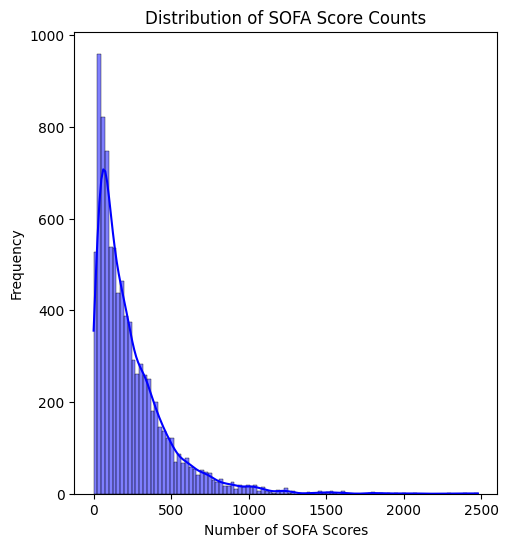

In [27]:
# Visualize the distribution of total 'sofa' counts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First subplot in a 1x2 grid
sns.histplot(sl_sofa_count['sofa_score_count'], kde=True, color='blue', edgecolor='black')
plt.title('Distribution of SOFA Score Counts')
plt.xlabel('Number of SOFA Scores')
plt.ylabel('Frequency')

한 stay 당 평균 240 번의 측정값 존재. 하지만 아예 측정값이 없거나, 필요한 시점에 없는 경우도 있을 것 같음.

주의할 점: 측정 후 24시간이 지나지 않은 데이터는 time window가 작아서 신뢰도가 떨어질 수 있음.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


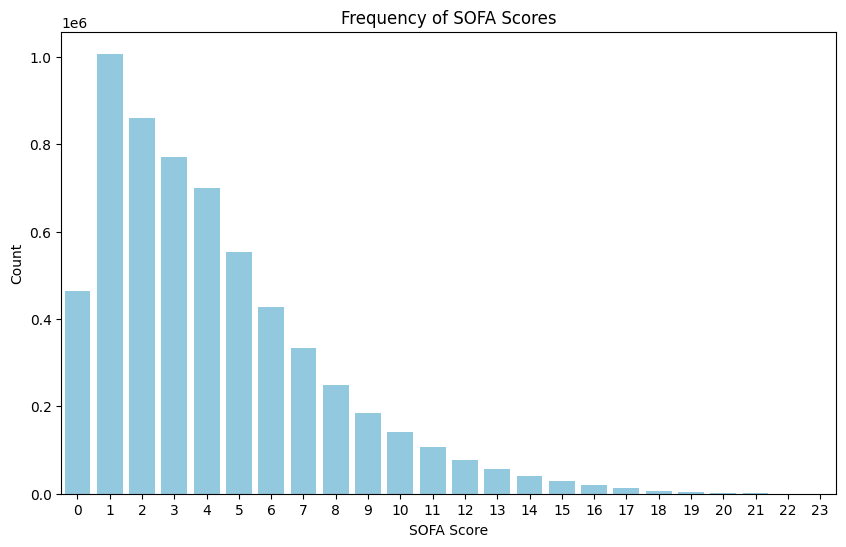

In [39]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sofa_24hours', data=sofa, color='skyblue')
plt.title('Frequency of SOFA Scores')
plt.xlabel('SOFA Score')
plt.ylabel('Count')
plt.show()

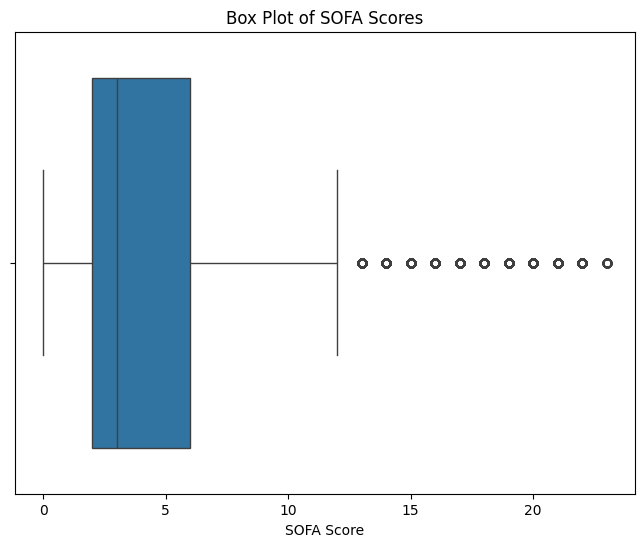

In [40]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='sofa_24hours', data=sofa)
plt.title('Box Plot of SOFA Scores')
plt.xlabel('SOFA Score')
plt.show()